## This does the comparison between fit function and GP fitting on 3.6fb-1 of data and injecting a Gaussian signal based on a fit to our q* samples

In [1]:
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


In [2]:
import george
from george.kernels import MyDijetKernelSimp


import math
import time
import numpy as np
import scipy.stats as ss
import scipy.special as ssp
import scipy.optimize as op
from iminuit import Minuit

#import ROOT as r
#import warnings
#from rootpy.plotting import Hist, Hist2D, Legend, Canvas
#import rootpy.plotting.root2matplotlib as rplt

## Section 1: including and visualizing 13 TeV dataset

In [3]:
xvalO = np.load("xvalO.npy")
yvalO = np.load("yvalO.npy")
xerrO = np.load("xerrO.npy")
xlowO = np.load("xlowO.npy")
xval = np.load("xval.npy")
yval = np.load("yval.npy")
xerr = np.load("xerr.npy")

toyList = np.load("toyList.npy")
lumiToyDict = np.load("lumiToyList.npy")
meanGPnom = np.load("initialGPfit.npy")
fixedHyperparams = np.load("fixedHyperparams.npy")
sigToys = np.load("signalToys.npy")
sigToysO = np.load("signalToysO.npy")

standardParamSets = [(1500,2000,250), (750 ,2500, 250), (200, 3000, 250), (75, 3500, 250), (50, 4000, 250), 
             (25, 4500, 250), (20, 5000, 250), (15,5500, 250), (15, 6000,250)]

### Gaussian Signal

In [4]:
def sig_model(x, N=1e5, mass=2000., width=100., xErr=xerr):
    return N*(np.exp(-(x-mass)**2/2/width/width)/np.sqrt(2*np.pi)/width)*xErr

### 4 parameters fit function

In [5]:
def model_3param(t, params, xErr=xerr): 
    p0, p1, p2 = params
    sqrts = 13000.
    return (p0 * ((1.-t/sqrts)**p1) * (t/sqrts)**(p2))*(xErr)  #1./(t/sqrts)
def model_5param(t, params, xErr=xerr): 
    p0, p1, p2, p3, p4 = params
    sqrts = 13000.
    return (p0 * ((1.-t/sqrts)**p1) * (t/sqrts)**(p2+p3*np.log(t/sqrts)+p4*np.log(t/sqrts)**2))*(xErr)

## Set up minimization. Look at GP and fit function background only fits to data, and GP and fit function signal+background fits to data+signal

### Calculate bin by bin significance
### calculate bin p value, convert to significance (z). If z is negative, set to 0. If bkg < data, make z negative

In [6]:
def calcSignificance(Data, Bkg):
    pvals = []
    zvals = []
    chi2 = 0
    for i, nD in enumerate(Data):
        nB = Bkg[i]
        if nD != 0:
            if nB > nD:
                #pval = 1.-r.TMath.Gamma(nD+1.,nB)
                pval = 1.-ssp.gammainc(nD+1.,nB)
            else:
                #pval = pval = r.TMath.Gamma(nD,nB)
                pval = ssp.gammainc(nD,nB)
            prob = 1-2*pval
            if prob > -1 and prob < 1:
                #zval = math.sqrt(2.)*r.TMath.ErfInverse(prob)
                zval = math.sqrt(2.)*ssp.erfinv(prob)
            else:
                zval = np.inf
                #print "crap"
            if zval > 100: zval = 20
            if zval < 0: zval = 0
            if (nD < nB): zval = -zval
        else: zval = 0
            
        zvals.append(zval)
        chi2 += ((nD - nB) ** 2 / abs(nB)) #/len(nB)
    return zvals, chi2

'''
if D != 0:
pval = PoissonPval(D,B)
frac = probtosigma(pval)
if frac > 100: frac = 20
if frac < 0: frac = 0
if (D<B): frac = -frac
else: 0

poissonPval:
if d>= b: Gamma(d,b)
else: 1-Gamma(d+1, b)

probtosigma: 
if 1-2*pval > -1 and < 1: z = sqrt(2)* ErfInverse(1-2*pval)
'''

def simpleLogPoisson(x, par):
    if x < 0: 
        #print "crap"
        return np.inf
    elif (x == 0): return -1.*par
    else:
        #lnpoisson = x*np.log(par)-par-r.TMath.LnGamma(x+1.)
        lnpoisson = x*np.log(par)-par-ssp.gammaln(x+1.)
        return lnpoisson
    
def makeToys(dataset, nPseudo=1000, lumi = 3.6):
    toys = []
    for n in range(nPseudo):
        pseudo = np.random.poisson(dataset*lumi/3.6)
        toys.append(pseudo)
    return toys

def removeZeros(data):
    indices = [i for i, x in enumerate(data) if x == 0]
    newylist=[]
    newxlist=[]
    newxerrlist=[]
    for k in range(len(data)):
        if k not in indices:
            newylist.append(data[k])
            newxlist.append(xvalO[k])
            newxerrlist.append(xerrO[k])
    return np.array(newylist), np.array(newxlist), np.array(newxerrlist)

### Calculate NLL for fit function using poisson statistics - with or without signal. lnprob functions calls logLike function to calculate NLL.

### Minimize NLL of fit function.  fit functions call Minuit to minimize lnLike functions. Kick initial parameters, constrain parameters.  Minimize NLL of fit function with signal - add in signal strength parameter

In [15]:
class logLike_3ff_fitsig:
    def __init__(self, x, y, xe):
        self.x = x
        self.y = y
        self.xe = xe
    def __call__(self, p0, p1, p2, Num, mu, sigma):
        params = p0, p1, p2
        bkgFunc = model_3param(self.x, params, self.xe)  
        signal = sig_model(self.x, Num, mu, sigma, self.xe)
        logL = 0
        for ibin in range(len(self.y)):
            data = self.y[ibin]
            bkg = bkgFunc[ibin] 
            sig = signal[ibin]
            logL += -simpleLogPoisson(data, bkg+sig)
        try:
            logL
            return logL
        except:
            return np.inf

def fit_3ff_fitsig(lnprob, Print = True):
  #  np.random.seed(1234)
    bestval = np.inf
    bestargs = (0., 0., 0., 0., 0., 0.)
    passedFit = False
    numRetries = 0
   # while not passedFit and numRetries < 5:
    for i in range(100):
        init0 = np.random.random() * 1.
        init1 = np.random.random() * 8.
        init2 = np.random.random() * 6.
        init3 = np.random.random() * 5000.
        init4 = np.random.random() * 4000.
        init5 = np.random.random() * 200.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, errordef = 0.5,
                  p0 = init0, p1 = init1, p2 = init2, Num = init3, mu = init4, sigma = init5,
                  error_p0 = 1e-2, error_p1 = 1e-2, error_p2 = 1e-2, 
                  error_Num = 1., error_mu = 1., error_sigma = 1.,
                  limit_p0 = (0, 100.), limit_p1 = (-100., 100.), limit_p2 = (-100., 100.), 
                  limit_Num = (1, 50000), limit_mu = (1500, 7000), limit_sigma = (100, 500))
        fit = m.migrad()
        
        '''
        if fit[0]['is_valid']: 
            passedFit=True
     
            
        if numRetries == 4: 
            print "retry number = ", 5, ": failed fits"
            bestval=np.inf
            bestargs=(0, 0, 0, 0, 0, 0, 0, 0)
        numRetries+=1 


        '''
        if m.fval < bestval:
            bestval = m.fval
            bestargs = m.args

    if Print:
        print "min LL",bestval
        print "best fit vals", bestargs
    return bestval, bestargs

### Minimize NLL of GP using george lnlikelihood function - logLike functions calls gp.lnlikelihood to calculate NLL. 

### Minimize NLL of GP. call Minuit to minimize logLike functions. Kick initial parameters, constrain parameters. Minimize NLL of GP with signal - add in signal strength parameter

In [12]:
def model_gp(params, t, xerr=xerr): 
    #global xerr
    p0, p1, p2 = params
    sqrts = 13000.
    return (p0 * (1.-t/sqrts)**p1 * (t/sqrts)**(p2))*xerr

class logLike_gp_sig_fixedH:
    def __init__(self, x, y, xerr):
        self.x = x
        self.y = y
        self.xerr = xerr
    def __call__(self, Num, mu, sigma):
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        kernel = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d = sub)
        gp = george.GP(kernel)
        try:
            gp.compute(self.x, np.sqrt(self.y))
            signal = sig_model(self.x, Num, mu, sigma, self.xerr)
            return -gp.lnlikelihood(self.y - model_gp((p0,p1,p2), self.x, self.xerr)-signal)
        except:
            return np.inf        
        
def fit_gp_sig_fixedH_minuit(lnprob, Print = True):
    #np.random.seed(1234)
    bestval = np.inf
    bestargs = (0, 0, 0)
    passedFit = False
    numRetries = 0
    #while not passedFit and numRetries < 5:
    for i in range(100):
        init0 = np.random.random() * 5000.
        init1 = np.random.random() * 4000.
        init2 = np.random.random() * 200.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, errordef = 0.5,
                  Num = init0, mu = init1, sigma = init2, 
                  error_Num = 1., error_mu = 1., error_sigma = 1.,
                  limit_Num = (1, 50000), limit_mu = (1500, 7000), limit_sigma = (100, 500)) 
        fit = m.migrad()
        '''
        if fit[0]['is_valid']: 
            passedFit=True
        if numRetries == 4: 
            print "retry number = ", 5, ": failed fits"
            bestval=np.inf
            bestargs=(0, 0, 0, 0, 0, 0, 0, 0)
        numRetries+=1
        '''
        if m.fval < bestval:
            bestval = m.fval
            bestargs = m.args     
            

    if Print:
        print "min LL", bestval
        print "best fit vals",bestargs
    return bestval, bestargs

In [9]:
def basicPlot(xs, ys, bkgs, title, col='g'):
    f, (ax1) = plt.subplots(1, sharex=True, figsize=(12,12))
    f.suptitle(title, fontsize=30)
    dataPlot = ax1.errorbar(xs, ys, marker='o', ls='None', yerr = np.sqrt(ys), c='black', markersize=10, label="QCD MC")
    bkgPlot, = ax1.plot(xs, bkgs, color=col, linewidth=3.0, label="GP fit")
    ax1.legend()
    ax1.set_ylabel('Events', fontsize=20)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.set_yscale('log', nonposy="clip")
    ax1.set_xscale('log')
    ax1.set_xlim([1000, 7500])
    ax1.set_ylim([0.01, 2e6])

## Figures 8 - 11

### VARY WIDTH

In [ ]:

massDict_2 = {#2000: 50000,
            #2500: 10000,
            3000: 5000,
            #3500: 1000,
            #4000: 500, 
            #4500: 200, 
            #5000: 100,
            5500: 50}
            #6000: 25}

listSTD_paramN_dict_2={}
listGP_paramN_dict_2={}
listSTD_paramM_dict_2={}
listGP_paramM_dict_2={}
listSTD_paramW_dict_2={}
listGP_paramW_dict_2={}
for m in massDict_2.keys():
    listSTD_param_n=[]
    listGP_param_n=[]
    listSTD_param_m=[]
    listGP_param_m=[]
    listSTD_param_w=[]
    listGP_param_w=[]
    wparamSets = [500, 400, 300, 250, 200, 100]
    for pSet in wparamSets:
        n = massDict_2[m]  
        w = pSet
        print n, m, w
        listSTD_paramToy_n=[]
        listGP_paramToy_n=[]
        listSTD_paramToy_m=[]
        listGP_paramToy_m=[]
        listSTD_paramToy_w=[]
        listGP_paramToy_w=[]
        for itoy, toy in enumerate(toyList[:10]): 
            if itoy%10 ==0: print itoy
            ytoy, xtoy, xtoyerr = removeZeros(toy)
     
            signalTemplate = sig_model(xtoy, n, m, w, xtoyerr)
            signalTemplate = np.random.poisson(np.around(signalTemplate))
            ydata = ytoy + signalTemplate
            
            signalTemplateO = sig_model(xvalO, n, m, w, xerrO)
            signalTemplateO = np.random.poisson(np.around(signalTemplateO))
            ydataO = toy + signalTemplateO
        
            #################################
            lnProb = logLike_3ff_fitsig(xvalO,ydataO,xerrO)
            bestval, best_fit_new = fit_3ff_fitsig(lnProb, False)
            if np.isinf(bestval): continue
            a1, a2, a3, Nff, Mff, Wff = best_fit_new

            listSTD_paramToy_n.append(Nff)
            listSTD_paramToy_m.append(Mff)
            listSTD_paramToy_w.append(Wff)
            #########################################

            lnProb = logLike_gp_sig_fixedH(xtoy, ydata, xtoyerr)
            bestval, best_fit = fit_gp_sig_fixedH_minuit(lnProb, False)
            if np.isinf(bestval): continue
                
            N, M, W = best_fit
            listGP_paramToy_n.append(N)
            listGP_paramToy_m.append(M)
            listGP_paramToy_w.append(W)


        listSTD_param_n.append([np.mean(listSTD_paramToy_n, axis=0), np.std(listSTD_paramToy_n, axis=0)/len(toy)])
        listGP_param_n.append([np.mean(listGP_paramToy_n, axis=0), np.std(listGP_paramToy_n, axis=0)/len(toy)])
        listSTD_param_m.append([np.mean(listSTD_paramToy_m, axis=0), np.std(listSTD_paramToy_m, axis=0)/len(toy)])
        listGP_param_m.append([np.mean(listGP_paramToy_m, axis=0), np.std(listGP_paramToy_m, axis=0)/len(toy)])
        listSTD_param_w.append([np.mean(listSTD_paramToy_w, axis=0), np.std(listSTD_paramToy_w, axis=0)/len(toy)])
        listGP_param_w.append([np.mean(listGP_paramToy_w, axis=0), np.std(listGP_paramToy_w, axis=0)/len(toy)])

    listSTD_paramN_dict_2[m] = listSTD_param_n
    listGP_paramN_dict_2[m] = listGP_param_n
    listSTD_paramM_dict_2[m] = listSTD_param_m
    listGP_paramM_dict_2[m] = listGP_param_m
    listSTD_paramW_dict_2[m] = listSTD_param_w
    listGP_paramW_dict_2[m] = listGP_param_w
    
    print listSTD_paramN_dict_2
print "I'm done"


5000 3000 500
0
5000 3000 400
0
5000 3000 300
0
5000 3000 250
0
5000 3000 200
0
5000 3000 100
0


In [ ]:
print "hi"

In [ ]:
massDict_2 = {#2000: 50000,
            #2500: 10000,
            3000: 5000,
            #3500: 1000,
            #4000: 500, 
            #4500: 200, 
            #5000: 100,
            5500: 50}
            #6000: 25}


sortMass2 = sorted(massDict_2.keys())

for m in sortMass2:
    wparamSets = [500,400,300,250,200, 100]
    N = massDict_2[m]

    plt.figure()
    plt.title("GP mass = " + str(m) + " N = "+str(N))
    plt.plot(wparamSets, wparamSets, ls='-', color='black')
    plt.errorbar(wparamSets,[listGP_paramW_dict_2[m][i][0] for i in range(len(wparamSets))],yerr = np.sqrt([listGP_paramW_dict_2[m][i][1] for i in range(len(wparamSets))]), marker="o", linestyle="None")
    plt.xlabel('sigma true', fontsize=15)
    plt.ylabel('sigma predicted', fontsize=15)
    plt.xlim([90, 510])
    plt.ylim([90, 510])
    
    plt.figure()
    plt.title("STD mass = " + str(m) + " N = "+str(N))
    plt.plot(wparamSets, wparamSets, ls='-', color='black')
    plt.errorbar(wparamSets,[listSTD_paramW_dict_2[m][i][0] for i in range(len(wparamSets))],yerr = np.sqrt([listSTD_paramN_dict_2[m][i][1] for i in range(len(wparamSets))]), marker="o", linestyle="None")
    plt.xlabel('sigma true', fontsize=15)
    plt.xlim([90, 510])
    plt.ylim([90, 510])
    plt.ylabel('sigma predicted', fontsize=15)

'''
binsm = np.linspace(1500, 6000, 100)
binsn = 10 ** np.linspace(np.log10(10), np.log10(50000))

print "masses"    
for m in sortMass2:
    wparamSets = [500,400,300,250, 200, 100]
    N = massDict_2[m]

    plt.figure()
    plt.title("GP mass = " + str(m) + " N = "+str(N))
    plt.hist([listGP_paramM_dict_2[m][i][0]  for i in range(len(wparamSets))], binsm)
    plt.xlabel('m predicted', fontsize=15)
    
    plt.figure()
    plt.title("STD mass = " + str(m) + " N = "+str(N))
    plt.hist([listSTD_paramM_dict_2[m][i][0] for i in range(len(wparamSets))], binsm)
    plt.xlabel('m predicted', fontsize=15)

print "widths"
for m in sortMass2:
    wparamSets = [500,400,300,250, 200, 100]
    N = massDict_2[m]

    plt.figure()
    plt.title("GP mass = " + str(m) + " N = "+str(N))
    plt.hist([listGP_paramN_dict_2[m][i][0] for i in range(len(wparamSets))], binsn)
    plt.xlabel('N predicted', fontsize=15)
    plt.gca().set_xscale("log")
    
    plt.figure()
    plt.title("STD mass = " + str(m) + " N = "+str(N))
    plt.hist([listSTD_paramN_dict_2[m][i][0] for i in range(len(wparamSets))], binsn)
    plt.xlabel('N predicted', fontsize=15)
    plt.gca().set_xscale("log")
'''


### VARY N

In [50]:
massDict = {#2000: [50000, 40000, 30000, 20000, 10000, 5000, 1000, 500],
            #2500: [10000, 7500, 5000, 2500, 1000, 500, 100],
            3000: [5000, 2500, 2000, 1500, 1000, 500],
            #3500: [1000, 750, 500, 250, 100, 50],
            #4000: [500, 250, 100, 50, 25], 
            #4500: [200, 100, 75, 50, 25], 
            #5000: [100, 75, 50, 25, 10],
            5500: [200, 150, 100, 50, 25]}
            #6000: [25, 20, 25, 10]}

listSTD_paramN_dict={}
listGP_paramN_dict={}
listSTD_paramM_dict={}
listGP_paramM_dict={}
listSTD_paramW_dict={}
listGP_paramW_dict={}
for m in massDict.keys():
    nparamSets = massDict[m]
    listSTD_param_n=[]
    listGP_param_n=[]
    listSTD_param_m=[]
    listGP_param_m=[]
    listSTD_param_w=[]
    listGP_param_w=[]
    for pSet in nparamSets:
        n = pSet    
        w = 250
        print n, m, w
        listSTD_paramToy_n=[]
        listGP_paramToy_n=[]
        listSTD_paramToy_m=[]
        listGP_paramToy_m=[]
        listSTD_paramToy_w=[]
        listGP_paramToy_w=[]
        
        for itoy, toy in enumerate(toyList[:10]): 
            if itoy%10 ==0: print itoy
            ytoy, xtoy, xtoyerr = removeZeros(toy)
            signalTemplate = sig_model(xtoy, n, m, w, xtoyerr)
            signalTemplate = np.random.poisson(np.around(signalTemplate))
            ydata = ytoy + signalTemplate
            signalTemplateO = sig_model(xvalO, n, m, w, xerrO)
            signalTemplateO = np.random.poisson(np.around(signalTemplateO))
            ydataO = toy + signalTemplateO
        
            #################################
            lnProb = logLike_3ff_fitsig(xvalO,ydataO,xerrO)
            bestval, best_fit_new = fit_3ff_fitsig(100, lnProb)
            a1, a2, a3, Nff, Mff, Wff = best_fit_new

            listSTD_paramToy_n.append(Nff)
            listSTD_paramToy_m.append(Mff)
            listSTD_paramToy_w.append(Wff)
            #########################################


            #print "making signal plots"
            #label="Fit Function bkg+signal: N="+str(n)+" m="+str(m)+" width="+str(w) + "\n Fit params: N="+str(round(Nff,1))+" m="+str(round(Mff,1))+" width="+str(round(Wff,1))
            #makePrettyPlots_signal(xvalO, ydataO, bkg2, bkgsig, label)
    
            lnProb = logLike_gp_sig_fixedH(xtoy,ydata, xtoyerr)
            bestval, best_fit = fit_gp_sig_fixedH_minuit(100, lnProb)
    
            N, M, W = best_fit

            #if M < 2000: continue
            print "n, m, w", N, M, W
            listGP_paramToy_n.append(N)
            listGP_paramToy_m.append(M)
            listGP_paramToy_w.append(W)

        listSTD_param_n.append([np.mean(listSTD_paramToy_n, axis=0), np.var(listSTD_paramToy_n, axis=0)/len(toy)])
        listGP_param_n.append([np.mean(listGP_paramToy_n, axis=0), np.var(listGP_paramToy_n, axis=0)/len(toy)])
        listSTD_param_m.append([np.mean(listSTD_paramToy_m, axis=0), np.var(listSTD_paramToy_m, axis=0)/len(toy)])
        listGP_param_m.append([np.mean(listGP_paramToy_m, axis=0), np.var(listGP_paramToy_m, axis=0)/len(toy)])
        listSTD_param_w.append([np.mean(listSTD_paramToy_w, axis=0), np.var(listSTD_paramToy_w, axis=0)/len(toy)])
        listGP_param_w.append([np.mean(listGP_paramToy_w, axis=0), np.var(listGP_paramToy_w, axis=0)/len(toy)])
        

    listSTD_paramN_dict[m] = listSTD_param_n
    listGP_paramN_dict[m] = listGP_param_n
    listSTD_paramM_dict[m] = listSTD_param_m
    listGP_paramM_dict[m] = listGP_param_m
    listSTD_paramW_dict[m] = listSTD_param_w
    listGP_paramW_dict[m] = listGP_param_w
    
    print listGP_paramN_dict
print "I'm done"


200 5500 250
0
n, m, w 219.044736944 5512.20362021 254.515373096
n, m, w 226.321768625 5493.75799022 280.33296014
n, m, w 217.079302464 5508.76119076 266.196210138
n, m, w 223.591232174 5495.25627815 278.497795097
n, m, w 217.693156685 5495.89837479 274.792498511
n, m, w 215.607492114 5493.59968136 271.054362389
n, m, w 209.367204532 5498.02360801 246.444497181
n, m, w 204.957303194 5509.40809331 248.291741685
n, m, w 217.241647461 5502.47176552 260.208527548
10
n, m, w 215.973208689 5505.70822889 261.955029461
n, m, w 206.874055529 5517.30327083 250.243110968
n, m, w 258.127082688 5546.61504765 296.996946937
n, m, w 216.187283621 5488.05693472 263.789113187
n, m, w 219.416740628 5507.94527148 287.880227277
n, m, w 216.702492648 5507.61474074 275.289391623
n, m, w 227.428377877 5499.68388388 265.170087446
n, m, w 214.881562304 2962.2668715 178.453424077
n, m, w 219.013442698 5499.49197139 265.269080118
n, m, w 239.943729967 5541.15787372 268.352391595
20
n, m, w 218.422493101 5508.0186

'\nbinsm = np.linspace(1500, 6000, 100)\nbinsw = np.linspace(100, 500, 100)\nprint "masses"    \nfor m in sortMass:\n    nparamSets = massDict[m]\n\n    plt.figure()\n    plt.title("GP mass = " + str(m) + " sigma = 250")\n    plt.hist([listGP_paramM_dict[m][i][0]  for i in range(len(nparamSets))], binsm)\n    plt.xlabel(\'m predicted\', fontsize=15)\n    \n    plt.figure()\n    plt.title("STD mass = " + str(m) + " sigma = 250")\n    plt.hist([listSTD_paramM_dict[m][i][0] for i in range(len(nparamSets))], binsm)\n    plt.xlabel(\'m predicted\', fontsize=15)\n\nprint "widths"\nfor m in sortMass:\n    nparamSets = massDict[m]\n\n    plt.figure()\n    plt.title("GP mass = " + str(m) + " sigma = 250")\n    plt.hist([listGP_paramW_dict[m][i][0] for i in range(len(nparamSets))], binsw)\n    plt.xlabel(\'w predicted\', fontsize=15)\n\n    \n    plt.figure()\n    plt.title("STD mass = " + str(m) + " sigma = 250")\n    plt.hist([listSTD_paramW_dict[m][i][0] for i in range(len(nparamSets))], bins

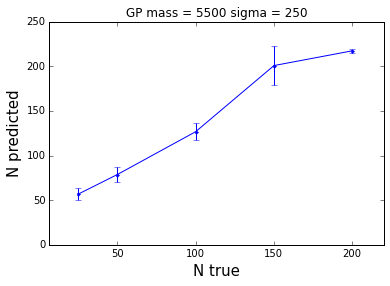

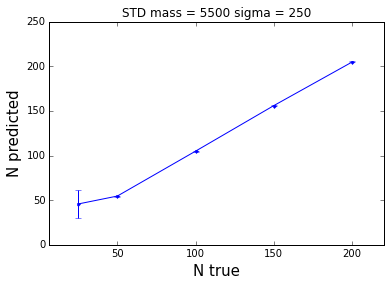

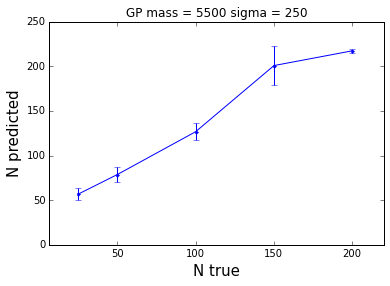

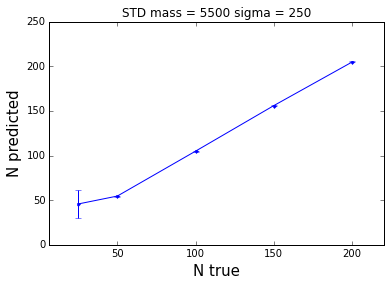

In [51]:
massDict = {#2000: [50000, 40000, 30000, 20000, 10000, 5000, 1000, 500],
            #2500: [10000, 7500, 5000, 2500, 1000, 500, 100],
            3000: [5000, 2500, 2000, 1500, 1000, 500], #[5000, 2500, 1000, 500, 100, 50],
            #3500: [1000, 750, 500, 250, 100, 50],
            #4000: [500, 250, 100, 50, 25], 
            #4500: [200, 100, 75, 50, 25], 
            #5000: [100, 75, 50, 25, 10],
            5500: [200, 150, 100, 50, 25]}#[50, 40, 30, 20]}
            #6000: [25, 20, 25, 10]}


sortMass = sorted(massDict.keys())

for m in sortMass:
    nparamSets = massDict[m]

    plt.figure()
    plt.title("GP mass = " + str(m) + " sigma = 250")
    plt.plot(nparamSets,nparamSets, c='black', ls='-')
    plt.errorbar(nparamSets,[listGP_paramN_dict[m][i][0] for i in range(len(nparamSets))],yerr = np.sqrt([listGP_paramN_dict[m][i][1] for i in range(len(nparamSets))]), marker="o", linestyle="None")
    plt.xlabel('N true', fontsize=15)
    plt.ylabel('N predicted', fontsize=15)
    plt.xlim([nparamSets[-1]*.25, nparamSets[0]*1.1])
    
    plt.figure()
    plt.title("STD mass = " + str(m) + " sigma = 250")
    plt.plot(nparamSets,nparamSets, c='black', ls='-')
    plt.errorbar(nparamSets,[listSTD_paramN_dict[m][i][0] for i in range(len(nparamSets))],yerr = np.sqrt([listSTD_paramN_dict[m][i][1] for i in range(len(nparamSets))]), marker="o", linestyle="None")
    plt.xlabel('N true', fontsize=15)
    plt.ylabel('N predicted', fontsize=15)
    plt.xlim([nparamSets[-1]*.25,nparamSets[0]*1.1])

'''
binsm = np.linspace(1500, 6000, 100)
binsw = np.linspace(100, 500, 100)
print "masses"    
for m in sortMass:
    nparamSets = massDict[m]

    plt.figure()
    plt.title("GP mass = " + str(m) + " sigma = 250")
    plt.hist([listGP_paramM_dict[m][i][0]  for i in range(len(nparamSets))], binsm)
    plt.xlabel('m predicted', fontsize=15)
    
    plt.figure()
    plt.title("STD mass = " + str(m) + " sigma = 250")
    plt.hist([listSTD_paramM_dict[m][i][0] for i in range(len(nparamSets))], binsm)
    plt.xlabel('m predicted', fontsize=15)

print "widths"
for m in sortMass:
    nparamSets = massDict[m]

    plt.figure()
    plt.title("GP mass = " + str(m) + " sigma = 250")
    plt.hist([listGP_paramW_dict[m][i][0] for i in range(len(nparamSets))], binsw)
    plt.xlabel('w predicted', fontsize=15)

    
    plt.figure()
    plt.title("STD mass = " + str(m) + " sigma = 250")
    plt.hist([listSTD_paramW_dict[m][i][0] for i in range(len(nparamSets))], binsw)
    plt.xlabel('w predicted', fontsize=15)


    
'''


#plt.plot(nparamSets,nparamSets, c='black', ls='-')
plt.errorbar([30000, 25000, 20000, 15000, 10000, 5000, 1000, 500],[listGP_param_n_fixN[i][0] for i in range(len(listGP_param_n_fixN))],yerr = np.sqrt([listGP_param_n_fixN[i][1] for i in range(len(listGP_param_n_fixN))]), marker=".", linestyle="-")
plt.xlabel('N true', fontsize=15)
plt.ylabel('N predicted', fontsize=15)


plt.figure()
print listGP_param_w_fixW
plt.errorbar([500, 400, 300, 200, 100, 50],[listGP_param_w_fixW[i][0] for i in range(len(listGP_param_w_fixW))],yerr = np.sqrt([listGP_param_w_fixW[i][1] for i in range(len(listGP_param_w_fixW))]), marker=".", linestyle="-")
plt.xlabel('sigma true', fontsize=15)
plt.ylabel('sigma predicted', fontsize=15)

plt.figure()
print listGP_param_w_fixW_2
plt.errorbar([500, 400, 300, 200, 100, 50],[listGP_param_w_fixW_2[i][0] for i in range(len(listGP_param_w_fixW_2))],yerr = np.sqrt([listGP_param_w_fixW_2[i][1] for i in range(len(listGP_param_w_fixW_2))]), marker=".", linestyle="-")
plt.xlabel('sigma true', fontsize=15)
plt.ylabel('sigma predicted', fontsize=15)

plt.figure()
print listGP_param_m_fixN_2
plt.errorbar([125, 100, 75, 50, 25, 10],[listGP_param_n_fixN_2[i][0] for i in range(len(listGP_param_n_fixN_2))],yerr = np.sqrt([listGP_param_n_fixN_2[i][1] for i in range(len(listGP_param_n_fixN_2))]), marker=".", linestyle="-")
plt.xlabel('N true', fontsize=15)
plt.ylabel('N predicted', fontsize=15)
#plt.ylim(1, 500)




In [239]:

def model_mean(t):
    global xerr
    p0, p1, p2 = fixedHyperparams[5:]
    sqrts=13000.
    return (p0 * (1.-t/sqrts)**p1 * (t/sqrts)**(p2))*xerr

  
class logLike_mean:
    def __init__(self, x, y, xerr):
        self.x = x
        self.y = y
        self.xerr = xerr
    def __call__(self, Amp, decay, length, power, sub):
        kernel = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)
        mean = model_mean(self.x)
        gp = george.GP(kernel, mean = model_mean)
        try:
            gp.compute(self.x, np.sqrt(self.y))
            return -gp.lnlikelihood(self.y)
        except:
            return np.inf  
        
def fit_gp_mean(num, lnprob):
    #np.random.seed(1234)
    bestval = np.inf
    bestargs = (0, 0, 0, 0, 0)
    for i in range(num):
        init0 = np.random.random() * 1e6+1
        init1 = np.random.random() * 400.
        init2 = np.random.random() * 10. 
        init3 = np.random.random() * -100.
        init4 = np.random.random() * 650.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0,
                  Amp = init0, decay = init1, length = init2, power = init3, sub = init4, 
                  error_Amp = 1e1, error_decay = 1e1, error_length = 1e-1, error_power = 1e-1, 
                   error_sub = 1e-1,
                  limit_Amp = (1, 1e15), limit_decay = (0, 500), limit_length = (0, 200), 
                   limit_power = (-200, 200), limit_sub = (0, 1000)) 
        m.migrad()
        if m.fval < bestval:
            bestval = m.fval
            bestargs = m.args
    print "min LL", bestval
    print "best fit vals",bestargs
    return bestval, bestargs


lnProb = logLike_mean(xval,yval, xerr)
bestval, best_fit_new = fit_gp_mean(100, lnProb)
Amp, decay, length, power, sub = best_fit_new
kernel = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)
def model_mean2(t):
    global xerr
    p0, p1, p2 = fixedHyperparams[5:]
    print len(t), len(xerr)
    sqrts=13000.
    return (p0 * (1.-t/sqrts)**p1 * (t/sqrts)**(p2))*xerr
gp = george.GP(kernel, mean = model_mean2)
gp.compute(xval, np.sqrt(yval))
meanGP = gp.predict(yval, xval)[0]
makePrettyPlots(xval, yval, meanGP,"")

min LL 616.037424389
best fit vals (6028451418812.025, 255.0940102907686, 0.13705241112997868, -152.98243553398368, 982.3672594842421)
74 74
74 74


TypeError: makePrettyPlots() takes at least 4 arguments (3 given)

## DONE